# [[Dacon] 영화 관객수 예측 경진대회](https://dacon.io/competitions/official/235536/overview/description)
- 평가 산식 : RMSE
- 변수 설명
    - title : 영화의 제목
    - distributor : 배급사
    - genre : 장르
    - release_time : 개봉일
    - time : 상영시간(분)
    - screening_rat : 상영등급
    - director : 감독이름
    - dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
    - dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
    - num_staff : 스텝수
    - num_actor : 주연배우수
    - box_off_num : 관객수

## 1. EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus']=False

In [2]:
df = pd.read_csv(os.getcwd() + '/data/movie_num/movies_train.csv')
display(df.head())
print(df.info())
print(df.shape)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB
None
(600, 12)


In [6]:
# 중복행 개수
df.duplicated().sum()

0

In [24]:
cate_cols = df.select_dtypes(include='object').columns
for col in cate_cols:
    print(f'- "{col}" 컬럼의 범주 개수: {len(df[col].unique())}')

- "title" 컬럼의 범주 개수: 600
- "distributor" 컬럼의 범주 개수: 169
- "genre" 컬럼의 범주 개수: 12
- "release_time" 컬럼의 범주 개수: 330
- "screening_rat" 컬럼의 범주 개수: 4
- "director" 컬럼의 범주 개수: 472


In [4]:
# release_time을 datetime으로 변경
release_time = df['release_time'] # 원본 저장
df['release_time'] = pd.to_datetime(df['release_time'])

# release_time에서 연도, 월, 일, 요일 추출
df['year'] = df['release_time'].dt.year
df['month'] = df['release_time'].dt.month
df['day'] = df['release_time'].dt.day
df['weekday'] = df['release_time'].dt.weekday

# 불필요한 컬럼 삭제
df.drop(['title', 'distributor', 'director', 'release_time', 'dir_prev_bfnum'], axis=1, inplace=True)

df.head(3)

,genre,time,screening_rat,dir_prev_num,num_staff,num_actor,box_off_num,year,month,day,weekday
0,액션,96,청소년 관람불가,0,91,2,23398,2012,11,22,3
1,느와르,130,청소년 관람불가,2,387,3,7072501,2015,11,19,3
2,액션,123,15세 관람가,4,343,4,6959083,2013,6,5,2


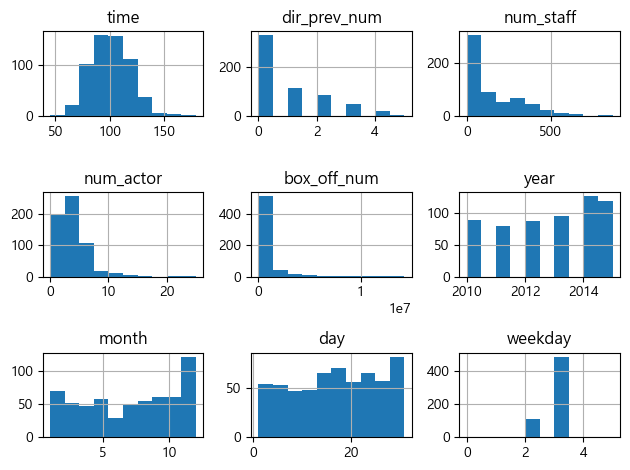

In [34]:
# 히스토그램
df.hist()
plt.tight_layout();

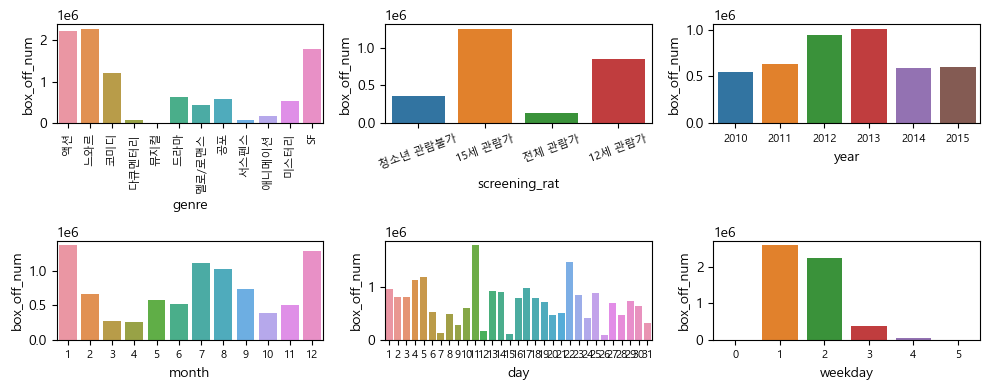

In [95]:
# 범주형 컬럼의 막대그래프
cat_features = ['genre', 'screening_rat', 'year', 'month', 'day', 'weekday']
fig, ax = plt.subplots(figsize=(10, 4), ncols=3, nrows=2)
for i, feature in enumerate(cat_features):
    row = int(i/3)
    col = i%3
    sns.barplot(x=feature, y='box_off_num', data=df, ax=ax[row][col], ci=None)
    ax[row][col].tick_params(axis='x', labelsize=8)
    ax[0][0].tick_params(axis='x', rotation=90)
    ax[0][1].tick_params(axis='x', rotation=20)
    plt.tight_layout()

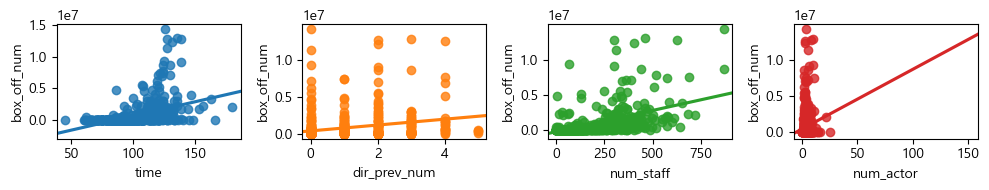

In [103]:
# 수치형 변수와 영화 관객수 간의 산점도
num_features = df.drop(cat_features, axis=1).columns
fig, ax = plt.subplots(figsize=(10, 2), ncols=4, nrows=1)
for i, feature in enumerate(num_features[:-1]):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y='box_off_num', data=df, ax=ax[col], ci=None)
    plt.tight_layout()

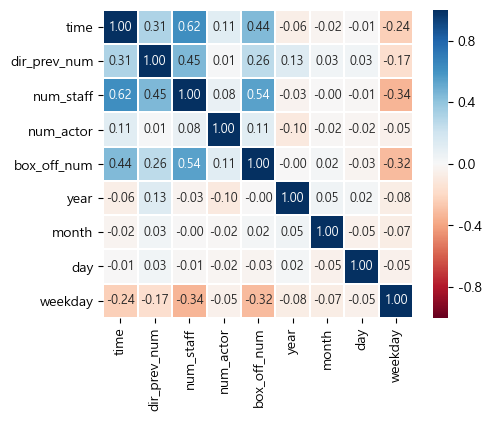

In [71]:
df_corr = df.corr()
plt.figure(figsize=(5,4))
sns.heatmap(df_corr, annot=True, cmap='RdBu', fmt='.2f', linewidth=.2, vmin=-1, vmax=1, annot_kws={'fontsize': 9});

[해석]
1. 결측치 존재 여부
	- dir_prev_bfnum 변수에서 270개의 결측치가 보이는데, 전체 데이터 600건 대비 약 절반 정도가 결측치 이므로 제거하였다.
1. 데이터 타입 설명
	- 종속변수인 box_off_num은 int형이고, 나머지 독립변수는 object, int, float형으로 구성되었다.
1. 종속변수와 독립변수의 상관관계
	- 상대적으로 높은 상관성을 보이는 변수는 num_staff이며, 상관계수값은 +0.54이다.
1. 독립변수 상관관계
	- 다중공선성을 의심할 만큼 상관성(0.9 이상)이 큰 변수는 없었다.
	- 가장 상관성이 높은 변수는 num_staff와 time이며 상관계수값은 +0.62이다.
1. 데이터 질을 향상시킬 수 있는 방법
	- release_time 변수를 datetime형으로 변환한 뒤에, 연도, 월, 일, 요일 값을 추출하였고, 기존의 release_time 변수는 삭제하였다.
	- 범주형 변수인 title, distributor, director 변수들은 범주의 개수가 많기에 원-핫 인코딩을 수행하면 컬럼수가 대폭 증가할 것이다. 따라서 모델 학습에 시간 소요가 클 것을 우려하여 분석 대상에서 제외하였다.
	- 하지만 genre와 screening_rat는 범주 개수가 상대적으로 적어서 분석 대상에 포함하였다.
	- num_staff, num_actor, 그리고 box_off_num 분포가 왼쪽으로 치우쳐져 있기에 정규화 및 로그 변환으로 정규 분포 형태로 바꾸어 주는 것이 좋을 것이다.

In [115]:
# 상영등급별 관객수 통계량
df[['screening_rat', 'box_off_num']].groupby('screening_rat').agg(['mean', 'median', 'max', 'min'])

box_off_num                        
                       mean    median       max min
screening_rat                                      
12세 관람가        8.449809e+05   19323.0  14262766  90
15세 관람가        1.247519e+06  242381.0  12983841  36
전체 관람가         1.351005e+05    8325.0   4802169  65
청소년 관람불가       3.641813e+05    3008.5   7072501   1

## 2. 통계 분석
### 1) z-test
- 귀무가설: 평균 영화 상영시간은 110 시간이다.
- 대립가설: 평균 영화 상영시간은 110 시간이 아니다.

In [128]:
def peam_test(sample, mean0, p_var, alpha=0.05):
    s_mean = np.mean(sample)
    n = len(sample)
    rv = stats.norm()
    interval = rv.interval(1-alpha)
    
    z = (s_mean-mean0) / np.sqrt(p_var/n)
    if interval[0] <= z <= interval[1]: print('귀무가설을 채택')
    else: print('귀무가설을 기각')
        
    if z < 0: p = rv.cdf(z)*2
    else: p = (1-rv.cdf(z))*2
    print(f'p-값은 {p:.3f}')

In [147]:
import scipy.stats as stats
np.random.seed(0)
sample = np.random.choice(df['time'], 50)
p_var = np.var(df.time)

peam_test(sample, 110, p_var)
print('-'*20, '\n<신뢰구간>')
print('신뢰구간:', stats.norm.interval(alpha=0.95, loc=np.mean(df['time']), scale = np.sqrt(p_var/len(df)) ) )
print(f'μ0인 110가 신뢰구간에 포함하지 않기에 귀무가설을 기각함.')

print('-'*20, '\n<검정통계량과 z-score 비교>')
z=( np.mean(sample) - 110 ) / np.sqrt(p_var/len(sample))
print(f'검정통계량 z값(=|{round(z, 4)}|) > z(0.025)(={round(stats.norm.isf(0.025), 4)}) 이므로 귀무가설을 기각함.')

귀무가설을 기각
p-값은 0.001
-------------------- 
<신뢰구간>
신뢰구간: (99.41646333529889, 102.31020333136777)
μ0인 110가 신뢰구간에 포함하지 않기에 귀무가설을 기각함.
-------------------- 
<검정통계량과 z-score 비교>
검정통계량 z값(=|-3.3786|) > z(0.025)(=1.96) 이므로 귀무가설을 기각함.


### 1) 일표본 t-검정 (모분산을 모른다고 가정함)
- 귀무가설: 평균 주연 배우수는 4명이다.
- 대립가설: 평균 주연 배우수는 4명이 아니다.

In [158]:
def pmean_test(sample, mean0, alpha=0.05):
    s_mean=np.mean(sample)
    u_var = np.var(sample, ddof=1)
    n = len(sample)
    rv = stats.t(df=n-1)
    interval = rv.interval(1-alpha)
    
    t = (s_mean - mean0) / np.sqrt(u_var/n)
    if interval[0] <= t <= interval[1]: print('귀무가설 채택')
    else: print('귀무가설 기각')
        
    if t < 0: p = rv.cdf(t) * 2
    else: p = (1-rv.cdf(t)) * 2
    print(f'p값은 {p:.3f}')
    
np.random.seed(1234)
sample = np.random.choice(df['num_actor'], 20)
pmean_test(sample, 4)
print('-'*20, '\n<신뢰구간>')
print('신뢰구간:', stats.t.interval(alpha=0.95, df=len(sample)-1, loc=np.mean(sample), scale = stats.sem(sample)))
print(f'μ0인 4가 신뢰구간에 포함하므로 귀무가설을 채택할 수 있음.')

print('-'*20, '\n<검정통계량과 t-score 비교>')
s_mean = np.mean(sample)
u_var = np.var(sample, ddof=1)
n = len(sample)
t = (s_mean-4) / np.sqrt(u_var/n)
print(f'검정통계량 t값(={round(t, 4)}) < t(0.025, {n})(={round(stats.t(n-1).isf(0.025), 4)}) 이므로 귀무가설을 채택함.')

귀무가설 채택
p값은 0.729
-------------------- 
<신뢰구간>
신뢰구간: (2.7632083699025425, 5.736791630097457)
μ0인 4가 신뢰구간에 포함하므로 귀무가설을 채택할 수 있음.
-------------------- 
<검정통계량과 t-score 비교>
검정통계량 t값(=0.3519) < t(0.025, 20)(=2.093) 이므로 귀무가설을 채택함.


In [161]:
# stats 패키지를 활용한 검정(간단함)
stats.shapiro(sample) # 정규성 만족
stats.ttest_1samp(sample, popmean=4) # 일표본 t검정

Ttest_1sampResult(statistic=0.3519363460283717, pvalue=0.7287592351957487)

### 3) 독립표본 t-검정(유의수준 0.05)
- 귀무가설: 2012년 평균 관객수와 2013년 평균 관객수에 차이가 없다.
- 대립가설: 2012년 평균 관객수와 2013년 평균 관객수에 차이가 있다.

In [19]:
import scipy.stats as stats

a_sample = np.random.choice(df.loc[df['year']==2012, 'box_off_num'], 20)
b_sample = np.random.choice(df.loc[df['year']==2013, 'box_off_num'], 17)

stats.shapiro(a_sample) # 정규성 만족 안함
stats.shapiro(b_sample) # 정규성 만족 안함

# 맨-휘트니U 검정
stats.mannwhitneyu(a_sample, b_sample) # 귀무가설을 채택함.

MannwhitneyuResult(statistic=178.0, pvalue=0.8191393543865961)

In [20]:
# 만약 정규성과 등분산성을 만족한다면
stats.ttest_ind(a_sample, b_sample) # 귀무가설 채택

Ttest_indResult(statistic=-0.17088369916604798, pvalue=0.8652992977012797)

In [29]:
def sp(data1, data2):
    df = len(data1) + len(data2) - 2
    s1 = (len(data1)-1) * (data1.std()**2)
    s2 = (len(data2)-1) * (data2.std()**2)
    sp = np.sqrt((s1+s2)/df)
    return sp

alpha=0.95
dof = len(a_sample) + len(b_sample)-2
diff_mean = np.mean(a_sample) - np.mean(b_sample)
s = sp(a_sample, b_sample)*(1/len(a_sample) + 1/len(b_sample))
print('<신뢰구간>')
print('CI:', stats.t.interval(alpha, dof, loc=diff_mean, scale=s))
print(f'두 집단의 평균 차이가 {round(diff_mean, 4)}인데, 신뢰구간에 포함하므로 귀무가설을 채택할 수 있음.')

print('-'*20, '\n<검정통계량과 t-score 비교>')
t = diff_mean / sp(a_sample, b_sample) / (1/len(a_sample) + 1/len(b_sample))**0.5
print(f'검정통계량 t값(=|{round(t, 4)}|) < t(0.025, {dof})(={round(stats.t(dof).isf(0.025), 4)}) 이므로 귀무가설을 채택함.')

<신뢰구간>
CI: (-1000602.3130498376, 584793.9071674846)
두 집단의 평균 차이가 -207904.2029인데, 신뢰구간에 포함하므로 귀무가설을 채택할 수 있음.
-------------------- 
<검정통계량과 t-score 비교>
검정통계량 t값(=|-0.1756|) < t(0.025, 35)(=2.0301) 이므로 귀무가설을 채택함.


### 4) 분산분석(유의수준 0.05)
- 귀무가설: screening_rat에 따라 관객수에 차이가 없다.
- 대립가설: screening_rat에 따라 관객수에 차이가 있다.

In [31]:
df['screening_rat'].unique()

array(['청소년 관람불가', '15세 관람가', '전체 관람가', '12세 관람가'], dtype=object)

In [40]:
nokids = df.loc[df['screening_rat']=='청소년 관람불가', 'box_off_num']
fifteen = df.loc[df['screening_rat']=='15세 관람가', 'box_off_num']
allpeople = df.loc[df['screening_rat']=='전체 관람가', 'box_off_num']
twelve = df.loc[df['screening_rat']=='12세 관람가', 'box_off_num']

# 정규성 검정(모두 만족 못함)
print(stats.shapiro(nokids)); print(stats.shapiro(fifteen)); print(stats.shapiro(allpeople)); print(stats.shapiro(twelve))

# 크루크칼 왈리스 검정
stats.kruskal(nokids, fifteen, allpeople, twelve) # 귀무가설 기각

ShapiroResult(statistic=0.4230273962020874, pvalue=3.493528450743978e-25)
ShapiroResult(statistic=0.5457141399383545, pvalue=1.1726784649747811e-22)
ShapiroResult(statistic=0.23940962553024292, pvalue=1.2516528675285887e-19)
ShapiroResult(statistic=0.47243714332580566, pvalue=1.912598078794495e-17)


KruskalResult(statistic=51.76476633686402, pvalue=3.361554538378921e-11)

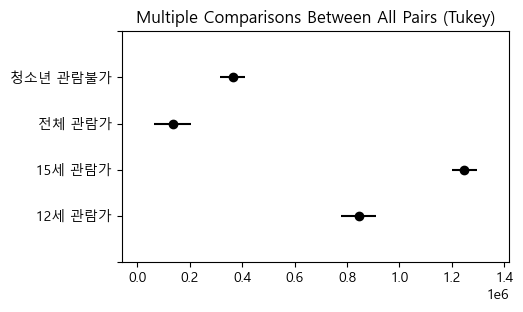

In [43]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
mc = MultiComparison(data=df['box_off_num'], groups=df['screening_rat'])
tuekeyhsd = mc.tukeyhsd(alpha=0.95)
fig = tuekeyhsd.plot_simultaneous(figsize=(5, 3))

In [44]:
tuekeyhsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
12세 관람가,15세 관람가,402537.7416,0.2454,286501.7136,518573.7696,True
12세 관람가,전체 관람가,-709880.4454,0.029,-847233.619,-572527.2719,True
12세 관람가,청소년 관람불가,-480799.5735,0.1168,-596644.5956,-364954.5515,True
15세 관람가,전체 관람가,-1112418.187,0.0,-1232571.5414,-992264.8327,True
15세 관람가,청소년 관람불가,-883337.3151,0.0,-978158.2169,-788516.4134,True
전체 관람가,청소년 관람불가,229080.8719,0.7347,109111.968,349049.7758,True


## 3. 머신러닝

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

df_ohe = pd.get_dummies(df, drop_first=True) # 원-핫 인코딩 수행

X = df_ohe.drop(['box_off_num'],axis=1)
y = df_ohe['box_off_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [32]:
# rmse 계산 함수 생성
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, 'RMSE', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses=[]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [34]:
# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression RMSE 1528787.095
Ridge RMSE 1530392.413
Lasso RMSE 1528789.919


[1528787.0953709728, 1530392.4131620638, 1528789.9192952623]

- 세 모델의 RMSE값이 매우 높음을 알 수 있다.

In [63]:
def get_top_error_data(model, y_test, pred, n_top=5):
    pred = model.predict(X_test)
    result_df = pd.DataFrame(y_test.values, columns=['real'])
    result_df['predicted'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real']-result_df['predicted'])
    print(result_df.sort_values('diff', ascending=False)[:n_top])

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_top_error_data(model, y_test, pred, n_top=5)
    if model != lasso_reg: print('-' * 35)

         real  predicted        diff
164  12323595  2101166.0  10222429.0
132  12983841  3708492.0   9275349.0
19    9350351  1011713.0   8338638.0
108    467697  3321417.0   2853720.0
36     317505  3128045.0   2810540.0
-----------------------------------
         real  predicted        diff
164  12323595  2113806.0  10209789.0
132  12983841  3694792.0   9289049.0
19    9350351   906387.0   8443964.0
108    467697  3312563.0   2844866.0
36     317505  3128770.0   2811265.0
-----------------------------------
         real  predicted        diff
164  12323595  2101187.0  10222408.0
132  12983841  3708476.0   9275365.0
19    9350351  1011545.0   8338806.0
108    467697  3321408.0   2853711.0
36     317505  3128046.0   2810541.0


- 위에서 실제값과 예측값이 어느 정도 차이 나는지 확인한 결과, 상당한 값이 차이가 있었다.
- 따라서 num_staff, num_actor을 포함한 수치형 변수를 스케일링하였고, box_off_num을 로그변환 하였다.

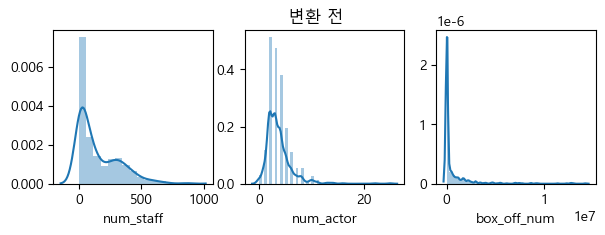

In [68]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(7, 2))
for i, feature in enumerate(['num_staff', 'num_actor', 'box_off_num']):
    col = i % 3
    sns.distplot(df_ohe[feature], ax=ax[col])
plt.suptitle('변환 전');

In [78]:
# 범주형 변수 원-핫 인코딩
df_ohe = pd.get_dummies(df, drop_first=True) # 원-핫 인코딩 수행

# 종속변수 로그변환
df_ohe['box_off_num'] = np.log1p(df_ohe['box_off_num'])

X = df_ohe.drop(['box_off_num'],axis=1)
y = df_ohe['box_off_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

In [77]:
df_ohe

,time,dir_prev_num,num_staff,num_actor,box_off_num,year,month,day,weekday,genre_공포,...,genre_멜로/로맨스,genre_뮤지컬,genre_미스터리,genre_서스펜스,genre_애니메이션,genre_액션,genre_코미디,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,96,0,91,2,10.060449,2012,11,22,3,0,...,0,0,0,0,0,1,0,0,0,1
1,130,2,387,3,15.771725,2015,11,19,3,0,...,0,0,0,0,0,0,0,0,0,1
2,123,4,343,4,15.755558,2013,6,5,2,0,...,0,0,0,0,0,1,0,1,0,0
3,101,2,20,6,12.291640,2012,7,12,3,0,...,0,0,0,0,0,0,1,0,1,0
4,108,1,251,2,13.088575,2010,11,4,3,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,111,1,510,7,14.204231,2014,8,13,2,0,...,0,0,0,0,0,0,0,0,0,1
596,127,1,286,6,14.355762,2013,3,14,3,0,...,0,0,0,0,0,0,0,1,0,0
597,99,0,123,4,7.814400,2010,9,30,3,1,...,0,0,0,0,0,0,0,0,0,1
598,102,0,431,4,14.600565,2015,5,14,3,0,...,0,0,0,0,0,0,0,1,0,0


In [79]:
X_train_sc

array([[-0.90699057,  0.13713767, -0.8964045 , ..., -0.69577219,
         2.25542823, -0.70710678],
       [ 0.79184713,  0.99680668,  1.0712384 , ..., -0.69577219,
        -0.44337478,  1.41421356],
       [-0.56722303,  0.99680668, -0.84767031, ...,  1.43725204,
        -0.44337478, -0.70710678],
       ...,
       [ 0.62196336, -0.72253133, -0.23240117, ..., -0.69577219,
        -0.44337478,  1.41421356],
       [-1.24675811, -0.72253133, -0.79284435, ..., -0.69577219,
         2.25542823, -0.70710678],
       [ 1.18824259, -0.72253133, -0.08010682, ..., -0.69577219,
        -0.44337478,  1.41421356]])